Universidade Federal de Santa Catarina<br>
Departamento de Engenharia Elétrica e Eletrônica<br>
EEL7514 / EEL7513 / EEL410250 - Aprendizado de Máquina
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bU}{\mathbf{U}}$
$\newcommand{\bu}{\mathbf{u}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\calS}{\mathcal{S}}$


# Exercício 8: Redes Convolucionais

Neste exercício você irá utilizar redes convolucionais para reconhecimento de imagens. Além de treinar uma rede a partir do zero, você irá investigar a técnica de ajuste fino (*fine tuning*) a partir de uma rede pré-treinada (*transfer learning*).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import sys
import tensorflow as tf
print('Python', sys.version.split(' ')[0])
print('TensorFlow', tf.__version__)
#print('GPU:', tf.config.list_physical_devices('GPU'))
devs = tf.python.client.device_lib.list_local_devices()
devs = {devs[i].device_type: devs[i].physical_device_desc for i in range(len(devs))}
if 'GPU' in devs:
  print('GPU:', devs['GPU'].split('name: ')[1].split(', ')[0])
else:
  print('GPU: None')

Python 3.6.9
TensorFlow 2.3.0
GPU: Tesla P100-PCIE-16GB


In [2]:
def plots(history):
  plt.figure(figsize=(14,4))
  plt.subplot(1,2,1)
  plt.plot(history.history['loss'], '.-', label='Train loss')
  if 'val_loss' in history.history.keys():
    plt.plot(history.history['val_loss'], '.-', label='Val loss')
  plt.xlabel('Epochs');
  plt.legend();
  plt.grid();
  plt.subplot(1,2,2)
  plt.plot(history.history['accuracy'], '.-', label='Train accuracy')
  plt.xlabel('Epochs');
  if 'val_accuracy' in history.history.keys():
    plt.plot(history.history['val_accuracy'], '.-', label='Val accuracy')
  plt.legend();
  plt.grid();

# 1. Treinando a partir do zero

## MNIST

1. Assim como no exercício anterior, carregue o conjunto MNIST e separe as últimas 5000 imagens como conjunto de validação. No entanto, desta vez não realize qualquer pré-processamento nas imagens (como escalonamento); isto será feito [internamente no modelo](https://keras.io/guides/preprocessing_layers/#preprocessing-data-before-the-model-or-inside-the-model) depois.

In [101]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [102]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=(5000/60000), random_state=0)

In [103]:
x_train = x_train.astype('uint8')
x_val = x_val.astype('uint8')

print(x_train.dtype)
print(f'Train shapes: {x_train.shape, y_train.shape}')
print(f'  Val shapes: {x_val.shape, y_val.shape}')
print(f' Test shapes: {x_test.shape, y_test.shape}')

uint8
Train shapes: ((55000, 28, 28), (55000,))
  Val shapes: ((5000, 28, 28), (5000,))
 Test shapes: ((10000, 28, 28), (10000,))


2. Usando o Keras, construa uma rede neural com pelo menos uma camada convolucional (`tf.keras.layers.Conv2D`) e confirme que não há nenhum erro de definição. Organize seu código em uma função de criação do modelo, conforme o exemplo abaixo (dê o nome que preferir). Utilize camadas de escalonamento e *reshape* conforme necessário.

#### Dicas
- Funções úteis: `tf.keras.layers.experimental.preprocessing.Rescaling`, `tf.keras.layers.Reshape`
- Camadas convolucionais 2D exigem que a entrada seja um tensor 3D, sendo o último eixo correspondente ao número de canais (no caso, apenas 1, para uma imagem em tons de cinza).

In [104]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras        import layers

In [156]:
def make_model():
  tf.random.set_seed(20)
  model = Sequential(
      [
        layers.Input(shape = (28,28)),
        layers.Reshape(input_shape = (28*28,), target_shape = (28,28,1)),
        layers.experimental.preprocessing.Rescaling(1./255),

        layers.Conv2D(filters = 32, kernel_size = (3,3), padding='same', activation = 'relu'),
        layers.BatchNormalization(scale=False),
        layers.MaxPooling2D(pool_size = (2,2)),
        layers.Dropout(0.2),

        layers.Conv2D(filters = 32, kernel_size = (3,3), padding='same', activation = 'relu'),
        layers.BatchNormalization(scale=False),
        layers.MaxPooling2D(pool_size = (2,2)),
        layers.Dropout(0.2),

        layers.Flatten(),
        Dense(128, activation = 'relu'),
        layers.Dropout(0.2),
        Dense(64, activation = 'relu'),
        layers.Dropout(0.2),
        Dense(10, activation = 'softmax')
      ]
  )
  return model

make_model().summary()

Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_72 (Reshape)         (None, 28, 28, 1)         0         
_________________________________________________________________
rescaling_75 (Rescaling)     (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_180 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_138 (Bat (None, 28, 28, 32)        96        
_________________________________________________________________
max_pooling2d_170 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_145 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_181 (Conv2D)          (None, 14, 14, 32)      

In [160]:
model = make_model()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_val,y_val))

Epoch 1/100
860/860 [==============================] - 3s 3ms/step - loss: 1.8253 - accuracy: 0.3450 - val_loss: 1.8088 - val_accuracy: 0.3524
Epoch 2/100
860/860 [==============================] - 3s 3ms/step - loss: 1.6990 - accuracy: 0.3903 - val_loss: 1.6352 - val_accuracy: 0.4112
Epoch 3/100
860/860 [==============================] - 3s 3ms/step - loss: 1.6716 - accuracy: 0.4000 - val_loss: 1.6539 - val_accuracy: 0.4068
Epoch 4/100
860/860 [==============================] - 3s 3ms/step - loss: 1.6536 - accuracy: 0.4073 - val_loss: 1.6152 - val_accuracy: 0.4264
Epoch 5/100
860/860 [==============================] - 3s 3ms/step - loss: 1.6423 - accuracy: 0.4118 - val_loss: 1.6191 - val_accuracy: 0.4162
Epoch 6/100
860/860 [==============================] - 3s 3ms/step - loss: 1.6297 - accuracy: 0.4154 - val_loss: 1.6222 - val_accuracy: 0.4126
Epoch 7/100
860/860 [==============================] - 3s 3ms/step - loss: 1.6245 - accuracy: 0.4167 - val_loss: 1.6189 - val_accuracy: 0.4190

In [161]:
train_evaluate = model.evaluate(x_train,y_train)

1719/1719 [==============================] - 3s 2ms/step - loss: 2.3033 - accuracy: 0.1041


3. Desenvolva (i.e., aprimore a arquitetura) e treine sua rede (a partir do zero), tentando conseguir uma acurácia de validação de pelo menos 99.2%. (Lembre que usando apenas camadas densas é difícil conseguir uma acurácia muito superior a 98%.) Em seguida, calcule a acurácia no conjunto de teste.

1. (OPCIONAL) Por que o uso de Dropout faz com que o desempenho de treinamento comece bastante inferior ao de validação?

#### Dicas
- Parta da arquitetura deste [tutorial](https://keras.io/examples/vision/mnist_convnet) (com os devidos ajustes feitos no item anterior) e adicione uma camada densa com um número suficiente de unidades. Lembre-se de (ao contrário do tutorial) trazer para dentro do modelo qualquer pré-processamento necessário.
- Visualize os gráficos do treinamento usando a função `plots` fornecida (ou a ferramenta TensorBoard).
- Ao usar camadas convolucionais com GPU, a execução paralelizada torna impossível garantir a reproducibilidade, portanto, não perca tempo com isso.

## (OPCIONAL) Fashion-MNIST

5. (OPCIONAL) Repita para o conjunto [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist), o qual também está [disponível no Keras](https://keras.io/api/datasets/fashion_mnist). Nesse caso, é suficiente aproveitar a mesma arquitetura do modelo e apenas (se necessário) alterar a taxa de aprendizado e o número de épocas. Sem muito esforço é possível conseguir uma acurácia de validação de 92% (em comparação com 87% para uma rede densa). Se desejar, visualize algumas imagens do conjunto de treinamento e algumas predições erradas no conjunto de teste.

## CIFAR-10

Agora, vamos utilizar um conjunto um pouco mais complexo, o [CIFAR-10](https://en.wikipedia.org/wiki/CIFAR-10), também [disponível no Keras](https://keras.io/datasets/).


In [162]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train.dtype:', x_train.dtype)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

x_train.dtype: uint8
(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


Observe que o `shape` do array `y` precisa ser corrigido:
- Para usar a perda `sparse_categorical_crossentropy`, `y` precisa ser um tensor 1D com valores em `[0, 1, ..., n_classes-1]`
- Para usar a perda `categorical_crossentropy`, `y` precisa ser um tensor 2D com *shape* `(n_samples, n_classes)` e codificação *one-hot*


In [163]:
# Make sure y is a 1D tensor, so we can use sparse_categorical_crossentropy loss
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

# Validation split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=5000, shuffle=False)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(45000, 32, 32, 3) (45000,)
(5000, 32, 32, 3) (5000,)
(10000, 32, 32, 3) (10000,)


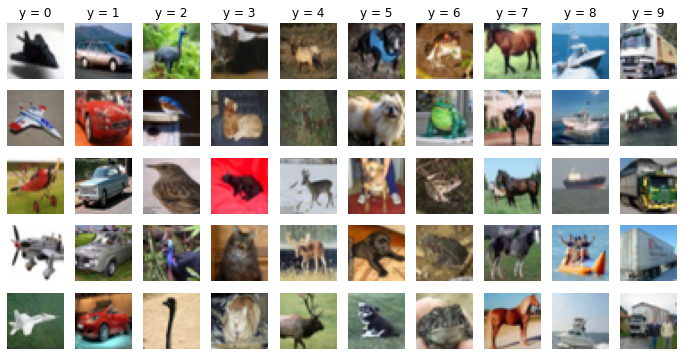

In [164]:
plt.figure(figsize=(12,6))
for i in range(5):
  for c in range(10):
    plt.subplot(5, 10, 10*i+c+1)
    img = x_train[y_train == c][i]
    plt.imshow(img)
    if i == 0:
      plt.title('y = {}'.format(c))
    plt.axis('off')

6. Inicialmente, apenas converta a mesma arquitetura utilizada no MNIST para o formato das imagens do CIFAR-10 e treine o modelo. Note que agora não é mais necessário usar uma camada `Reshape`. Certifique-se de escolher um batch size e taxa de aprendizado apropriadas. Observe que é difícil obter uma acurácia de validação superior a 73%.

7. Por que você acha que isso acontece? Explique.

In [176]:
def make_model():
  tf.random.set_seed(20)
  model = Sequential(
      [
        layers.Input(shape = (32,32,3)),
        layers.experimental.preprocessing.Rescaling(1./255),

        layers.Conv2D(filters = 32, kernel_size = (3,3), padding='same', activation = 'relu'),
        layers.BatchNormalization(scale=False),
        layers.MaxPooling2D(pool_size = (2,2)),
        layers.Dropout(0.2),

        layers.Conv2D(filters = 32, kernel_size = (3,3), padding='same', activation = 'relu'),
        layers.BatchNormalization(scale=False),
        layers.MaxPooling2D(pool_size = (2,2)),
        layers.Dropout(0.2),

        layers.Flatten(),
        Dense(128, activation = 'relu'),
        layers.Dropout(0.2),
        Dense(64, activation = 'relu'),
        layers.Dropout(0.2),
        Dense(10, activation = 'softmax')
      ]
  )
  return model

make_model().summary()

Model: "sequential_103"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_89 (Rescaling)     (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_212 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_170 (Bat (None, 32, 32, 32)        96        
_________________________________________________________________
max_pooling2d_202 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_209 (Dropout)        (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_213 (Conv2D)          (None, 16, 16, 32)        9248      
_________________________________________________________________
batch_normalization_171 (Bat (None, 16, 16, 32)     

In [ ]:
model = make_model()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_val,y_val))

In [178]:
model.save('CIFAR.h5')
model.save_weights('CIFAR-weigths'+'.h5')

In [179]:
model.evaluate(x_train,y_train)

1407/1407 [==============================] - 3s 2ms/step - loss: 0.1150 - accuracy: 0.9730


[0.11502812802791595, 0.9729999899864197]

In [180]:
model.evaluate(x_val,y_val)

157/157 [==============================] - 0s 2ms/step - loss: 0.8538 - accuracy: 0.7454


[0.8538186550140381, 0.7454000115394592]

### Data augmentation
Para melhorar o desempenho, utilizaremos a técnica de aumento de dados (*data augmentation*). Há duas formas principais de utilizar esta técnica no Keras:
- Usando a função [`tf.keras.preprocessing.image.ImageDataGenerator`](https://keras.io/api/preprocessing/image/#imagedatagenerator-class), a qual opcionalmente permite aplicar transformações aleatórias. Esta é a abordagem mais tradicional.
- Usando camadas de *data augmentation* como parte do modelo, as quais aplicam transformações aleatórias *somente* durante o treinamento (ficando inativas fora do treinamento). Esta é uma abordagem mais recente e ainda experimental. A principal vantagem é tornar as operações mais rápidas pelo uso da GPU, conforme explicado [neste tutorial](https://keras.io/guides/preprocessing_layers/#preprocessing-data-before-the-model-or-inside-the-model) e também [neste](https://keras.io/examples/vision/image_classification_from_scratch/#two-options-to-preprocess-the-data).

Para acelerar o treinamento usaremos aqui a segunda abordagem. Um exemplo é mostrado abaixo; você pode adicionar outras transformações se desejar.



In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomTranslation
data_augmentation = Sequential(
    [
     RandomTranslation(height_factor=0.1, width_factor=0.1),
     RandomFlip(mode='horizontal'),
    ],
    name='data_augmentation',
)

In [ ]:
def make_model():
  model = Sequential(
      [
       Input(shape=(32, 32, 3)),
       data_augmentation,
       ???
       Dense(10, activation='softmax'),
      ]
  )
  return model
make_model().summary()

**Obs:** Aparentemente há um bug ainda não resolvido nas camadas `RandomTranslation` e `RandomRotation`, conforme descrito [aqui](https://stackoverflow.com/questions/62339559/black-pixels-outside-the-border-when-using-keras-layers-experimental-preprocessi) e visualizado por exemplo [aqui](https://keras.io/examples/vision/image_classification_from_scratch/#using-image-data-augmentation), [aqui](https://keras.io/guides/transfer_learning/#using-random-data-augmentation) e nas imagens abaixo. (Não deveria haver bordas pretas nas imagens transformadas.) Felizmente esse defeito não afeta o desempenho de forma significativa.

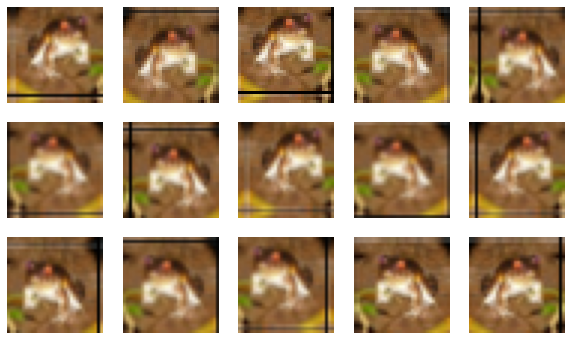

In [ ]:
plt.figure(figsize=(10, 6))
i = 0
for j in range(15):
  img = data_augmentation(x_train[[i]])[0].numpy()
  plt.subplot(3, 5, j+1)
  plt.imshow(img.astype('uint8'))
  plt.axis('off')

8. Treine o modelo até obter pelo menos 80% de acurácia de validação. Note que será preciso um número elevado de épocas (100 ou mais), o que deve levar vários minutos.

#### Dicas
- Certifique-se de usar uma taxa de aprendizado apropriada ao longo de todo o treinamento. Por exemplo:
 - Treine por N épocas com taxa constante, observe os resultados, depois continue o treinamento por mais N épocas, etc. Se em algum ponto o desempenho não estiver melhorando, reduza manualmente a taxa de aprendizado;
 - Utilize uma *callback* de decaimento, como [`ReduceLROnPlateau`](https://keras.io/api/callbacks/reduce_lr_on_plateau/) ou a genérica [`LearningRateScheduler`](https://keras.io/api/callbacks/learning_rate_scheduler/); ou
 - Utilize um valor pequeno constante e tenha bastante paciência.

-  Fique à vontade para aprimorar o modelo se desejar. Para facilitar, você pode se basear em quaisquer outras referências ou tutoriais disponíveis, como por exemplo: [Tutorial 1](https://www.learnopencv.com/image-classification-using-convolutional-neural-networks-in-keras) ou [Tutorial 2](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification). Note que alguns tutoriais estão desatualizados; por exemplo, a função `fit_generator` tornou-se obsoleta, tendo sido incorporada à função `fit`. No entanto, esteja ciente de que não é necessário um modelo muito complexo para obter a acurácia desejada.

# 2. Usando uma rede pré-treinada (*transfer learning & fine-tuning*)

1. Partindo de alguma [rede pré-treinada](https://keras.io/applications/)  fornecida pelo Keras, treine uma rede convolucional para [classificação entre gatos e cachorros](https://www.kaggle.com/c/dogs-vs-cats). Para isto, siga este [tutorial](https://keras.io/guides/transfer_learning) (provavelmente o mais atualizado no momento e escrito pelo próprio criador do Keras). Antes de seguir o tutorial, provavelmente será útil conhecer os conceitos básicos da [API funcional](https://keras.io/guides/functional_api/) do Keras.
1. (OPCIONAL) Experimente outros modelos pré-treinados e/ou outros conjuntos de dados. O [tutorial específico sobre EfficientNet](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/) pode ser interessante.
1. (OPCIONAL) Se desejar, você pode aplicar um modelo pré-treinado para classificaro CIFAR-10. No entanto, para obter um desempenho satisfatório nesse caso, será necessário previamente alargar (*resize*) as imagens para um tamanho mais próximo do das imagens da ImageNet (`224 x 224`), para que os filtros treinados possam ser relevantes. Por outro lado, um alargamento excessivo pode introduzir distorções (*artifacts*) que podem prejudicar o desempenho.

#### Dicas
- Antes de aplicar um modelo pré-treinado, geralmente é necessário realizar algum pré-processamento exigido pelo modelo. Ao invés de realizar esse pré-processamento manualmente, como feito no tutorial, é suficiente e mais conveniente utilizar a função `preprocess_input`, disponível no módulo de cada modelo pré-treinado. Por exemplo:
```python
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
base_model = ResNet50V2(include_top=False, input_shape=(150, 150, 3), pooling='avg')
base_model.trainable = False
(...)
x = preprocess_input(x)
x = base_model(x, training=False)
(...)
```
- Para inspecionar as camadas do modelo pré-treinado, utilize `base_model.summary()`
- Antes de utilizar um modelo com a opção `include_top=False`, é útil inspecionar o modelo completo (com a opção `include_top=True`), uma vez que será necessário recriar (e retreinar) as camadas finais removidas.
- Outras referências interessantes (embora mais antigas): [Tutorial 3](https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/) e [Tutorial 4](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/)

# 3. (OPCIONAL) Visualizando os padrões aprendidos

1. (OPCIONAL) Para alguma rede convolucional à sua escolha, visualize o que cada camada da rede "aprendeu"; mais precisamente, mostre exemplos de imagens de entrada que maximizam a ativação dos filtros em cada camada. Para isso, siga este [tutorial](https://keras.io/examples/vision/visualizing_what_convnets_learn/).